<h1>Машинне навчання</h1>
<p>Ю.С. Процик. Курс лекцій</p>
<div align="right"><em>Cформовано на основі <a href="https://mlcourse.ai">відкритого курсу</a> Юрія Кашницького</em></div>

# <center>Тема 4. Лінійні моделі класифікації та регресії
    
## <center>Частина 4. Криві валідації і навчання

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import validation_curve, learning_curve
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

Ми вже маємо уявлення про перевірку моделі, крос-валідацію і регуляризацію.
Тепер розглянемо головне питання:

**Якщо якість моделі нас не влаштовує, що робити?**

- Зробити модель складнішою чи спростити?
- Додати більше ознак?
- Чи нам просто потрібно більше даних для навчання?

Відповіді на ці запитання не завжди лежать на поверхні. Зокрема, іноді використання більш складної моделі призведе до погіршення показників. Або додавання спостережень не призведе до відчутних змін. Здатність прийняти правильне рішення і вибрати правильний спосіб поліпшення моделі, власне кажучи, і відрізняє хорошого фахівця від поганого.

Будемо працювати зі знайомими даними по відтоку клієнтів телеком-оператора.

In [2]:
data = pd.read_csv('../data/telecom_churn.csv').drop('State', axis=1)
data['International plan'] = data['International plan'].map({'Yes': 1, 'No': 0})
data['Voice mail plan'] = data['Voice mail plan'].map({'Yes': 1, 'No': 0})

y = data['Churn'].astype('int').values
X = data.drop('Churn', axis=1).values

**Логістичну регресію будемо навчати стохастичним градієнтним спуском. Поки пояснимо це тим, що так швидше, але далі в програмі у нас буде окрема лекція про це.**

In [3]:
alphas = np.logspace(-2, 0, 20)
sgd_logit = SGDClassifier(loss='log', n_jobs=-1, random_state=17)
logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=2)), 
                       ('sgd_logit', sgd_logit)])
val_train, val_test = validation_curve(logit_pipe, X, y,
                                       param_name='sgd_logit__alpha', param_range=alphas, cv=5,
                                       scoring='roc_auc')

**Побудуємо валідаційні криві, що показують, як якість (ROC AUC) на навчальній і перевірочній вибірці змінюється зі зміною параметра регуляризації.**

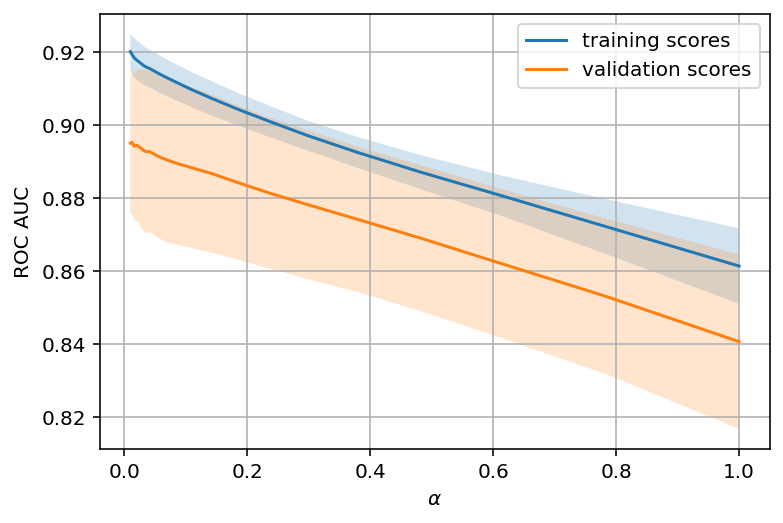

In [4]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
    facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(alphas, val_train, label='training scores')
plot_with_err(alphas, val_test, label='validation scores')
plt.xlabel(r'$\alpha$'); plt.ylabel('ROC AUC')
plt.legend()
plt.grid(True);

Тенденцію видно відразу, і вона дуже часто зустрічається.

1. Для простих моделей тренувальна і валідаційна помилка знаходяться десь поруч, і вони великі. Це говорить про те, що модель **недонавчена**: тобто вона не має достатню кількість параметрів.

2. Для сильно ускладнених моделей тренувальна і валідаційна помилки значно відрізняються. Це можна пояснити **перенавчанням**: коли параметрів занадто багато або не вистачає регуляризації, алгоритм може "відволікатися" на шум в даних і упускати основний тренд.

### Скільки потрібно даних?

Відомо, що чим більше даних використовує модель, тим краще. Але як нам зрозуміти в конкретній ситуації, чи допоможуть нові дані? Скажімо, чи доцільно нам витратити \$ N на працю асесорів, щоб збільшити вибірку вдвічі?

Оскільки нових даних поки може і не бути, розумно позмінювати розмір наявної навчальної вибірки і подивитися, як якість розв'язку задачі залежить від обсягу даних, на яких ми навчали модель. Так отримуються **криві навчання** (**learning curves**).

Ідея проста: ми відображаємо помилку як функцію від кількості прикладів, що використовувалися для навчання. При цьому параметри моделі фіксуються заздалегідь.

In [5]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(degree=2, alpha=0.01):
    train_sizes = np.linspace(0.05, 1, 20)
    logit_pipe = Pipeline([('scaler', StandardScaler()), ('poly', PolynomialFeatures(degree=degree)), 
                           ('sgd_logit', SGDClassifier(n_jobs=-1, random_state=17, alpha=alpha))])
    N_train, val_train, val_test = learning_curve(logit_pipe,
                                                  X, y, train_sizes=train_sizes, cv=5,
                                                  scoring='roc_auc')
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('AUC')
    plt.legend()

Давайте подивимося, що ми отримаємо для лінійної моделі. Коефіцієнт регуляризації виставимо великим.

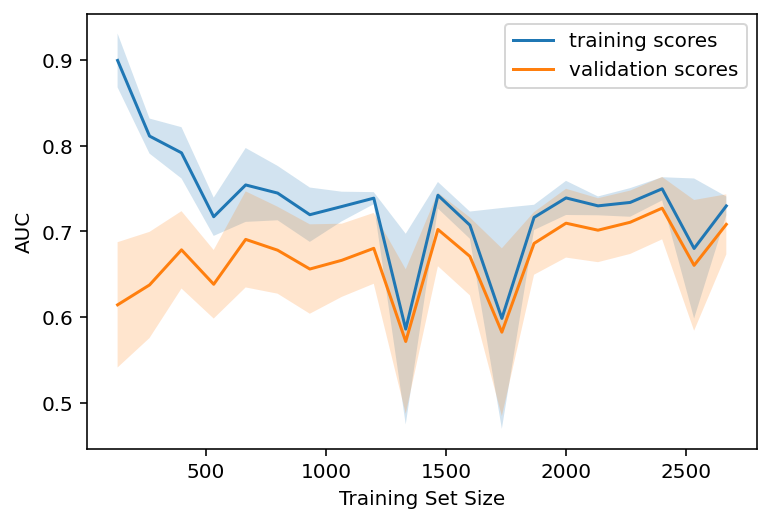

In [6]:
plot_learning_curve(degree=2, alpha=10)

Типова ситуація: для невеликого обсягу даних помилки на навчальній вибірці і в процесі крос-валідації досить сильно відрізняються, що вказує на перенавчання. Для тієї ж моделі, але з більшим об'ємом даних помилки "сходяться", що вказує на недонавчання.

Якщо додати ще дані, помилка на навчальній вибірці не буде рости, але з іншого боку, помилка на тестових даних не буде зменшуватися.

Виходить, помилки "зійшлися", і додавання нових даних не допоможе. Власне, це випадок – найцікавіший для бізнесу. Можлива ситуація, коли ми збільшуємо вибірку в 10 разів. Але якщо не міняти складність моделі, це може і не допомогти. Тобто стратегія "налаштував один раз – далі використовую 10 раз" може і не працювати.

Що буде, якщо змінити коефіцієнт регуляризації?
Бачимо хорошу тенденцію – криві поступово сходяться, і якщо далі рухатися вправо (додавати в модель дані), можна ще підвищити якість на валідації.

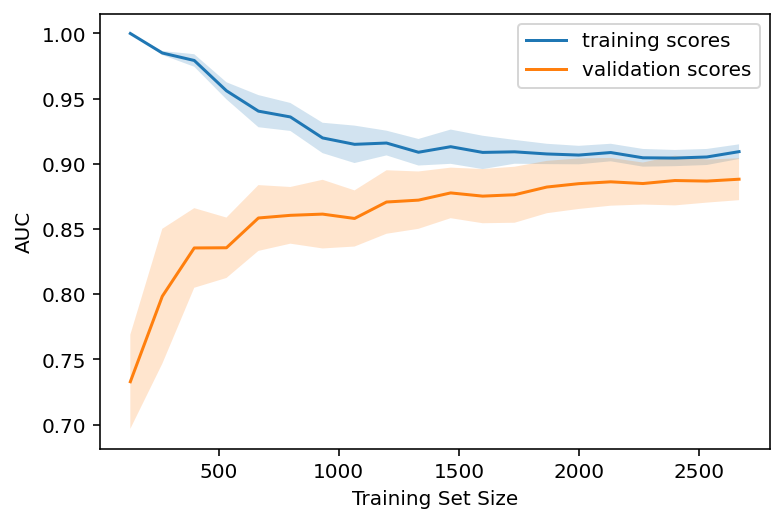

In [7]:
plot_learning_curve(degree=2, alpha=0.05)

А якщо ускладнити ще більше?

Виявляється перенавчання – AUC падає як на навчанні, так і на валідації.

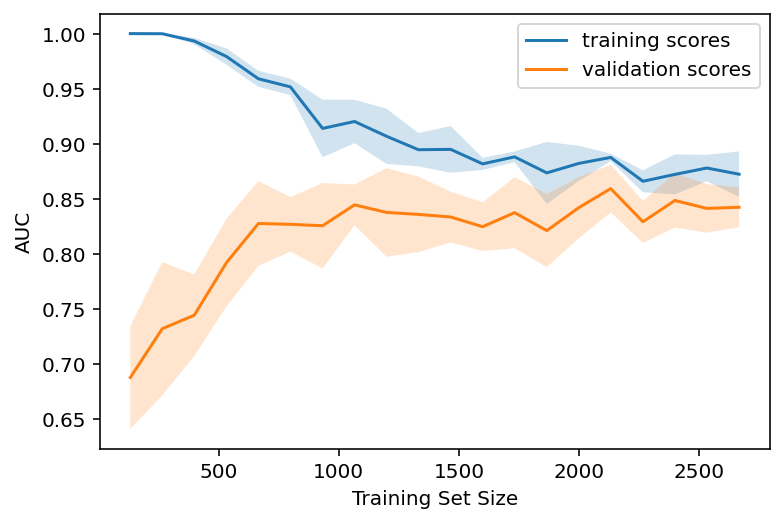

In [8]:
plot_learning_curve(degree=2, alpha=1e-4)

Будуючи подібні криві, можна зрозуміти, в який бік рухатися, і як правильно налаштувати складність моделі на нових даних.

### Висновки

- Помилка на навчальній вибірці сама по собі нічого не говорить про якість моделі.
- Крос-валідаційна помилка показує, наскільки добре модель підлаштовується під дані (наявний тренд в даних), зберігаючи при цьому здатність узагальнення на нові дані.
- **Валідаційна крива** представляє собою графік, що показує результат на тренувальній і валідаційній вибірці в залежності від **складності моделі**:
  + якщо дві криві розташовуються близько, і обидві помилки великі, – це ознака *недонавчання*;
  + якщо дві криві далеко одна від одної, – це показник *перенавчання*.
- **Крива навчання** – це графік, який показує результати на тренувальній і валідаційній вибірці в залежності від кількості спостережень:
  + якщо криві зійшлися одна до одної, додавання нових даних не допоможе – треба міняти складність моделі;
  + якщо криві ще не зійшлися, додавання нових даних може поліпшити результат.